In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from numpy.random import seed
seed(1337)

import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [2]:
# If this is not set, bug because tf takes too much memory
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_data_dir = "dataset/Train"
val_data_dir = "dataset/Validation"
test_data_dir = "dataset/Test"
category_names = sorted(os.listdir('dataset/Train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'dataset/Train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))

In [4]:
img_height, img_width = 120,120
conv_base = vgg16.VGG16(weights='imagenet', include_top=False,
                        pooling='max',
                        input_shape = (img_width, img_height, 3))

In [5]:
# Disabling all VGG 16 layers for training
conv_base.trainable = False

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
#Number of images to load at each iteration
batch_size = 32

# only rescaling
train_datagen =  ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

# these are generators for train/test data that will read pictures 
# found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 12348 images belonging to 120 classes.
Total number of images for "validation":
Found 4116 images belonging to 120 classes.
Total number of images for "testing":
Found 4116 images belonging to 120 classes.


In [8]:
learning_rate = 5e-5
epochs = 40
steps_per_epoch = int(12000 / (batch_size))
validation_steps = int(1200 / (batch_size))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint  = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                        clipnorm = 1.),
              metrics=['acc'])

In [9]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True, 
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint]
                    )

Epoch 1/40
385/385 [==============================] - 29s 76ms/step - loss: 5.0374 - acc: 0.0095 - val_loss: 4.7947 - val_acc: 0.0173
Epoch 2/40
385/385 [==============================] - 29s 76ms/step - loss: 4.8249 - acc: 0.0133 - val_loss: 4.8439 - val_acc: 0.0140
Epoch 3/40
385/385 [==============================] - 30s 77ms/step - loss: 4.7424 - acc: 0.0175 - val_loss: 4.7505 - val_acc: 0.0173
Epoch 4/40
385/385 [==============================] - 30s 78ms/step - loss: 4.6751 - acc: 0.0269 - val_loss: 4.6369 - val_acc: 0.0299
Epoch 5/40
385/385 [==============================] - 30s 77ms/step - loss: 4.6128 - acc: 0.0330 - val_loss: 4.6370 - val_acc: 0.0411
Epoch 6/40
385/385 [==============================] - 30s 78ms/step - loss: 4.5548 - acc: 0.0427 - val_loss: 4.6661 - val_acc: 0.0296
Epoch 7/40
385/385 [==============================] - 30s 77ms/step - loss: 4.5019 - acc: 0.0481 - val_loss: 4.4365 - val_acc: 0.0673
Epoch 8/40
385/385 [==============================] - 30s 77ms

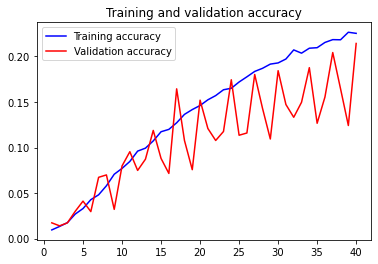

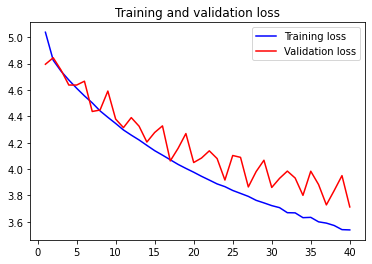

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')

In [13]:
import keras
from numba import cuda
# Clearing session as we will train model many time
keras.backend.clear_session()
# Releasing gpu memory directly with cuda
cuda.select_device(0)
cuda.close()